# Degree Distribution in PyC Subgraph (Full)

In [1]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.utils import *
from utils.graph_creation import *
from utils.motif_counts import *
from utils.visualization import *

### 1. Create PyC Subgraph

In [2]:
pyc_synapses = pd.read_csv('data/synapses.csv')
pyc_soma = pd.read_csv('data/soma.csv')

In [3]:
# create the simple directed graph (no self-loops, no multi-edges)
# treat multiple synapses as one connection
pyc_subgraph = synapses_to_connections(pyc_synapses[['pre','post']])
# remove self-loops
g_actual = remove_autapses(edges_to_graph(pyc_subgraph))
g_actual.add_nodes_from(pyc_soma["segment_id"])

In [4]:
locs = {n:string2array(np.array(pyc_soma[pyc_soma["segment_id"] == n]["loc"])[0]) for n in g_actual.nodes()}
axls = {n:np.array(pyc_soma[pyc_soma["segment_id"] == n]["axon_len"])[0] for n in g_actual.nodes()}
nx.set_node_attributes(g_actual, locs, "loc")
nx.set_node_attributes(g_actual, axls, "axl")

In [5]:
g_full = get_thresholded_graph(g_actual, axls, -1)
print(nx.info(g_full))

Name: 
Type: DiGraph
Number of nodes: 363
Number of edges: 1750
Average in degree:   4.8209
Average out degree:   4.8209


### 2. Compute Degree Sequences

In [6]:
# in-degree sequence
aic = np.array([g_full.in_degree(n) for n in g_full.nodes()])
# out-degree sequence
aoc = np.array([g_full.out_degree(n) for n in g_full.nodes()])

### 3. Compare the Degree Distribution with ER model

In [7]:
# calculate the connection probability
g_complete = nx.complete_graph(len(g_full.nodes()), nx.DiGraph())
p_connect = len(g_full.edges) / len(g_complete.edges)
p_connect

0.01331750452795154

In [8]:
%%time
# sample degree sequences from ER model, n=100
ric_sample, roc_sample = er_sample_degs(g_complete, p_connect)

CPU times: user 7.87 s, sys: 272 ms, total: 8.14 s
Wall time: 8.14 s


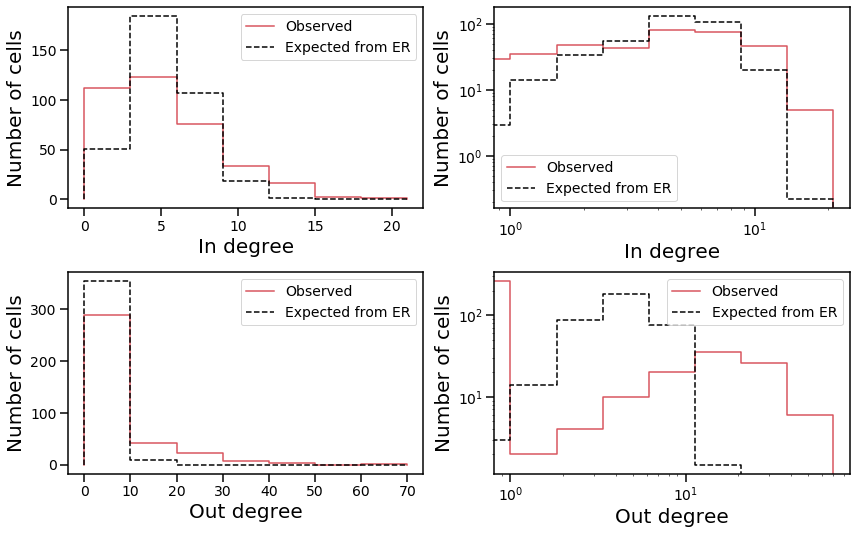

In [9]:
overlay_hists_log([aic, ric_sample], 
                  [aoc, roc_sample], 
                  ['Observed', 'Expected from ER'], 
                  ['Observed', 'Expected from ER'], 
                  title='', density=False, fname="full/full_degree_distribution")

### 4. Compare the Degree Distribution with generalized ER model

In [10]:
# calculate the connection probability
_, two_pr = compute_three_neuron_motif_probabilities_GE(g_full)
two_pr

{'pr_uni': 0.012845684367532684,
 'pr_bi': 0.00047182016041885454,
 'pr_null': 0.9738368111045158}

In [11]:
%%time
# sample degree sequences from generalized ER model, n=100
ug_complete = nx.complete_graph(len(g_full.nodes()))
ge_ric_sample, ge_roc_sample = er_gr_sample_degs(ug_complete, two_pr["pr_uni"], two_pr["pr_bi"])

CPU times: user 3.88 s, sys: 20 ms, total: 3.9 s
Wall time: 3.89 s


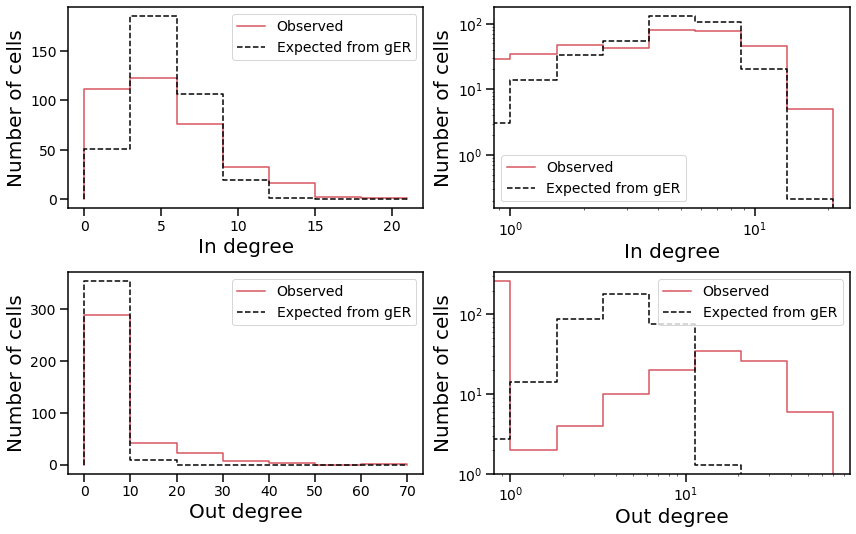

In [12]:
overlay_hists_log([aic, ge_ric_sample], 
                  [aoc, ge_roc_sample], 
                  ['Observed', 'Expected from gER'], 
                  ['Observed', 'Expected from gER'], 
                  title='', density=False, fname="full/full_degree_distribution_ge")